# Implement an Custom LSTM Model


## Problem Statement
You are tasked with implementing a simple [LSTM (Long Short-Term Memory)](https://en.wikipedia.org/wiki/Long_short-term_memory) model in PyTorch. The model should process sequential data using an LSTM layer followed by a fully connected (FC) layer. Your goal is two-fold: one is to implement a LSTM layer from scratch and another using inbuilt pytorch LSTM layer. Compare the results implementing the forward passes for both the LSTM models.


The long short-term memory (LSTM) cell can process data sequentially and keep its hidden state through time.

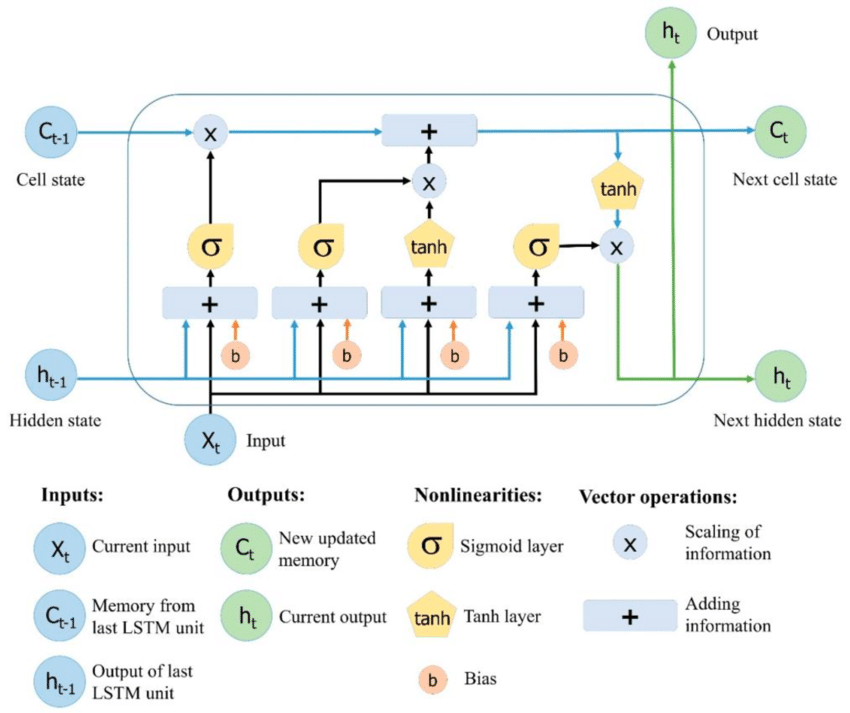


### Requirements
1. **Define the LSTM Model using Custom LSTM layer:**
   - Add a Custom LSTM layer to the model. The layer must take care of the hidden and cell states
   - Add a fully connected (FC) layer that maps the output of the LSTM to the final predictions.
   - Implement the forward method to:
      - Pass the input sequence through the LSTM.
      - Feed the output of the LSTM into the fully connected layer for the final output.
2. **Define the LSTM Model using in-built LSTM layer:**
   - Same as 1 with only difference that this time define the LSTM layer using pytorch nn.Module

### Constraints
   - The LSTM layer should be implemented with a single hidden layer.
   - Use a suitable number of input features, hidden units, and output size for the task.
   - Make sure the forward method returns the output of the fully connected layer after processing the LSTM output.

### ! Hint:
   - Add the LSTM layer and FC layer in `LSTMModel.__init__`.
   - Implement the forward pass to process sequences using the LSTM and FC layers.
   - Review Hidden and cell states computation here: [D2l.ai](https://d2l.ai/chapter_recurrent-modern/lstm.html)


## Solution

### Rephrase

1. Implement an LSTM model in two ways:
   1. With a custom LSTMCell from nn.Module: completely manually—input/forget/output gates, updating hidden/cell states, looping through time steps.
   2. With the built-in nn.LSTM: standard PyTorch implementation.

2. Goal:
   - Understand how LSTMs work "under the hood" (transition from user to developer),
   - Ensure that the forward pass (and gradients) are consistent in both implementations,
   - Learn to manage hidden/cell states manually—a key skill for research and complex architectures (e.g., teacher forcing in Seq2Seq).

3. Important: Do not use `nn.LSTMCell` — implement everything from scratch, including:
   - Gate computation: i_t = σ(W_ii x_t + b_ii + W_hi h_{t-1} + b_hi),
   - Cell state update: c_t = f_t * c_{t-1} + i_t * tanh(g_t),
   - Hidden state update: h_t = o_t * tanh(c_t).
   - each gate has its own separate transformation - including for the candidate g_t
   - The weights must be divided into 4 blocks: `[input, forget, cell_input, output]`

4. Compare Custom LSTM vs nn.LSTM Pytorch solution

### Why this is important:

Using `nn.LSTM` is a user-level task.

Implementing LSTM manually is a researcher-level task: this allows you to better understand the neural network, why gradients decay, how initialization affects it, and how to modify gates for the task (for example, add-dropout only to the input gate).

This knowledge will allow you to debug training dynamics, design custom RNN layers, and confidently discuss them.


### Implementation Notes

#### **Sequence models compared: RNNs, LSTMs, GRUs, and Transformers**

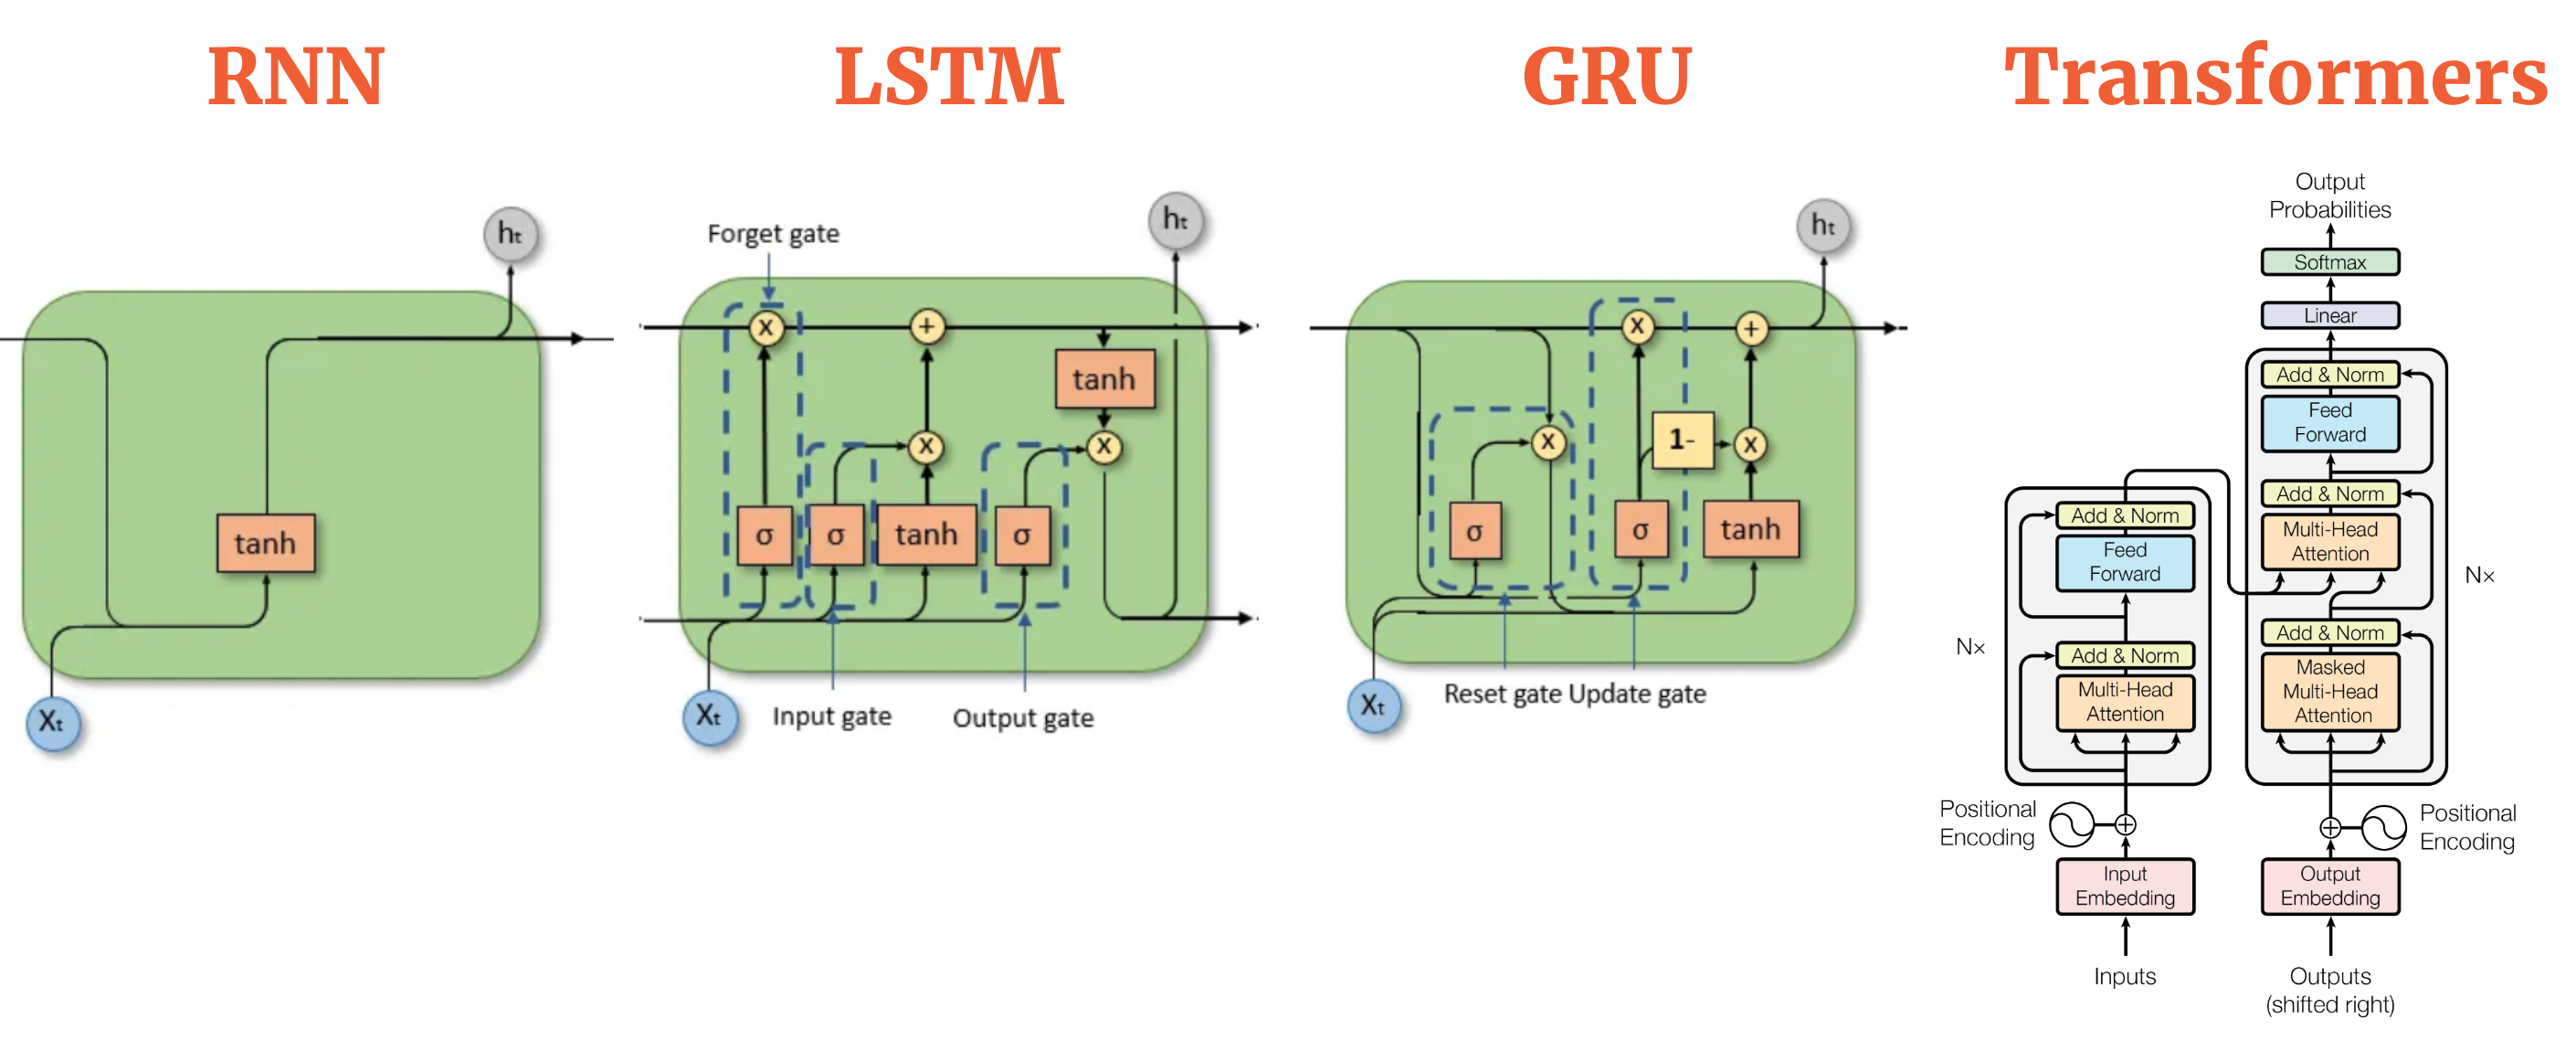

#### **Clasic RNN problems, and LSTM bonuses**

Vanishing Gradients:
- In a typical RNN: h_t = tanh(W_x * x_t + W_h * h_{t-1} + b)
- During backpropagation, the gradient must pass through ALL time steps.
- The derivative tanh ≤ 1, so when multiplying through many layers, the gradient approaches 0.
- Result: **The RNN "forgets" long-term dependencies.**

Exploding Gradients:
- If the weights are large, gradients can grow exponentially.
- This leads to numerical instability.

The key innovation of LSTM is Constant Error Carousel via cell state:
```
c_t = f_t * c_{t-1} + i_t * g_t
```

Look at the derivative:
```
∂c_t/∂c_{t-1} = f_t (forget gate)
```
Since f_t ≈ 1 (the sigmoid is close to 1), **the gradient can flow with virtually no damping!**

#### **About the memory mechanism in LSTM**

In RNN, the memory is h_t. But in LSTM, there are TWO memories:
- Hidden state (h_t) - short-term memory (as in RNN)
- Cell state (c_t) - long-term memory (the main innovation compare with RNN)

Based on this logic:
| Gate and State| Idea| Description |
| :------- | :------ | :-------- |
| Forget gate `fₜ`  | "What should I forget from long-term memory?"   | What fraction of the previous cell state cₜ₋₁ should be retained? (0 = forget everything, 1 = keep everything)     |
| Input gate `iₜ`  | "What should I write to long-term memory?" |How much to add the new candidate `gₜ` to the cell state.   |
| Output gate `oₜ`  | "What should I read from long-term memory to short-term memory?"  | `hₜ = oₜ * tanh(cₜ)` - that is: from cell state (`cₜ`, long-term memory) to hidden state (`hₜ`, short-term/output)   |
| Cell state `cₜ` | Long-term memory  |     |
| Hidden state `hₜ` | Short-term memory | Transferred to the next step and to the output.  |



Standard LSTM equations (from Hochreiter & Schmidhuber, 1997 and PyTorch docs):

```
i_t = σ(W_ii @ x_t + b_ii + W_hi @ h_{t-1} + b_hi)   # input gate
f_t = σ(W_if @ x_t + b_if + W_hf @ h_{t-1} + b_hf)   # forget gate
g_t = tanh(W_ig @ x_t + b_ig + W_hg @ h_{t-1} + b_hg)  # candidate (~"cell input")
o_t = σ(W_io @ x_t + b_io + W_ho @ h_{t-1} + b_ho)   # output gate

c_t = f_t * c_{t-1} + i_t * g_t                      # new cell state
h_t = o_t * tanh(c_t)                                # new hidden state
```

where `g_t` is not a "**gate**" but a candidate for updating the cell state (`{c}_t` in the original paper),
it is often called "**cell input**" or "**candidate memory**",
it passes through `tanh`, not `σ`, because it must be in `[-1, 1]`.

Sigmoid (σ) for input/forget/output gates:
- Range [0, 1] - interpreted as "proportion" or "probability"

Tanh for candidate gate:
- Range [-1, 1] - rich information representation
- Creates new candidates for addition to memory
- Can represent both positive and negative patterns


## Solution Code

Input: `x_t`
Previous states: `h_{t-1}`, `c_{t-1}`

        x_t, h_{t-1}
           ↓
    ┌──────────────────┐
    │  4 linear        │
    │   layers         │ → [i, f, g, o]  (4 gate tensors)
    └──────────────────┘
           ↓
    ┌──────────────────┐
    │ Gate activations │ → i=σ, f=σ, g=tanh, o=σ
    └──────────────────┘
           ↓
    ┌──────────────────┐
    │  Cell state      │ → c_t = f*c_{t-1} + i*g
    │  update          │
    └──────────────────┘
           ↓
    ┌──────────────────┐
    │  Hidden state    │ → h_t = o * tanh(c_t)
    │  computation     │
    └──────────────────┘


    

### Dimensions

**Please note**: In PyTorch, is a **storage convention** `nn.Linear` stores:
- weights as `[out_features, in_features]`, i.e. `[hidden_size, input_size]`,
- bias: `[out_features]`.

For LSTM:
- out_features = hidden_size
- in_features = input_size (for x_t) or hidden_size (for h_prev)

**I'm folowing the convention bellow.**

- **General**:
   - `x_t: [batch_size, input_size]`
   - `h_{t-1}: [batch_size, hidden_size]`

- **Input gate**:
   - `W_ii: [hidden_size, input_size]` (weights for `x_t`)
   - `W_hi: [hidden_size, hidden_size]` (weights for `h_prev`)
   - `b_i: [headen_size]`

- **Forget gate**:
   - `W_if: [hidden_size, input_size]` (weights for `x_t`)
   - `b_if: [headen_size]`
   - `W_hf: [hidden_size, hidden_size]` (weights for `h_prev`)
   - `b_hf: [headen_size]`

- **Candidate gate**:
   - `W_ig: [hidden_size, input_size]` (weights for `x_t`)
   - `b_ig: [headen_size]`
   - `W_hf: [hidden_size, hidden_size]` (weights for `h_prev`)
   - `b_hf: [headen_size]`

- **Output gate**:
   - `W_io: [hidden_size, input_size]` (weights for `x_t`)
   - `b_io: [headen_size]`
   - `W_ho: [hidden_size, hidden_size]` (weights for `h_prev`)
   - `b_ho: [headen_size]`


Equation with transposition and broadcasting:
- `h_prev = h_{t-1}`
- `i_t = σ(x_t @ W_ii^T + h_prev @ W_hi^T + b_i)`:
- `f_t = σ(x_t @ W_if^T + b_if + h_prev @ W_hf^T + b_hf)`
- `g_t = tanh(x_t @ W_ig^T + b_ig + h_prev @ W_hg^T + b_hg)`
- `o_t = σ(x_t @ W_io^T + b_io + h_prev @ W_ho^T + b_ho)`

Equation with transposition and broadcasting:
- `x_t @ W_ii^T`, `x_t @ W_if^T`, `x_t @ W_ig^T`, `x_t @ W_io^T`
   - -> `[batch_size, input_size]` * `[input_size, hidden_size]` -> `[batch_size, hidden_size]`
- `h_prev @ W_hi^T`, `h_prev @ W_hf^T`, `h_prev @ W_hg^T`, `h_prev @ W_ho^T`
   - -> `[batch_size, hidden_size]` * `[hidden_size, hidden_size]` -> `[batch_size, hidden_size]`
- `b_i`, `b_if`, `b_hf`, `b_ig`, `b_hf`, `b_io`, `b_ho`
   - -> broadcast [headen_size] -> `[batch_size, hidden_size]`
- result
   - -> `[batch_size, hidden_size]`



### Base Code

In [12]:
import torch
import torch.nn as nn
import math

class LSTMCellCustom(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, bias: bool = True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Pooled weights like in PyTorch for optimization
        self.W_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.W_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))

        if bias:
            self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
            self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

        self.reset_parameters()

    def extra_repr(self):
      """Nice view presenting as in PyTorch"""
      s = '{input_size}, {hidden_size}'
      if self.bias_ih is None:
          s += ', bias=False'
      return s.format(**self.__dict__)

    def reset_parameters(self):
      # https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
      stdv = 1.0 / math.sqrt(self.hidden_size)
      for weight in self.parameters():
          nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x, hidden_state=None):
      # x shape: [batch_size, input_size]

      if hidden_state is None:
          h_prev = torch.zeros(x.size(0), self.hidden_size, device=x.device)
          c_prev = torch.zeros(x.size(0), self.hidden_size, device=x.device)
      else:
          h_prev, c_prev = hidden_state

      # 1) Perform matrix multiplications for x_t and h_prev
      gates_ih = torch.mm(x, self.W_ih.t())  # x @ W_ih^T -> [batch_size, 4 * hidden_size]
      gates_hh = torch.mm(h_prev, self.W_hh.t())  # [batch_size, 4 * hidden_size]

      # 2) Add bias if there is one
      if self.bias_ih is not None:
        gates = gates_ih + self.bias_ih + gates_hh + self.bias_hh # Would be broadcasted automatically
      else:
        gates = gates_ih + gates_hh

      # 3) Divide the combined results into 4 gate tensors
      # gates: [batch_size, 4 * hidden_size] -> Divide into 4 parts based on the last dimension
      gate_slices = gates.chunk(4, dim=1) # 4 tensors [batch_size, hidden_size] each
      i_gate, f_gate, g_gate, o_gate = gate_slices

      # 4) Apply activations to each gate
      i_t = torch.sigmoid(i_gate) # P[0; 1]
      f_t = torch.sigmoid(f_gate) # P[0; 1]
      g_t = torch.tanh(g_gate) # [-1; 1]
      o_t = torch.sigmoid(o_gate) # P[0; 1]

      # 5) Compute the state updates (c_t, h_t)
      #     f_t * c_prev - discard some of the old memory
      #     i_t * g_t - add new information
      c_t = f_t * c_prev + i_t * g_t
      #     o_t * torch.tanh(c_t) - Show the filtered version of memory
      h_t = o_t * torch.tanh(c_t)

      return h_t, (h_t, c_t)

### Test

In [ ]:
def test_lstm_cell():
    input_size, hidden_size, batch_size = 10, 20, 4

    # Create cells
    cell_custom = LSTMCellCustom(input_size, hidden_size)
    cell_standard = nn.LSTMCell(input_size, hidden_size)

    # Copy weights
    with torch.no_grad():
        cell_standard.weight_ih.copy_(cell_custom.W_ih)
        cell_standard.weight_hh.copy_(cell_custom.W_hh)
        cell_standard.bias_ih.copy_(cell_custom.bias_ih)
        cell_standard.bias_hh.copy_(cell_custom.bias_hh)

    # Test data
    x = torch.randn(batch_size, input_size)
    h0 = torch.randn(batch_size, hidden_size)
    c0 = torch.randn(batch_size, hidden_size)

    # Forward
    h_custom, (h1_custom, c1_custom) = cell_custom(x, (h0, c0))
    h_standard, c1_standard = cell_standard(x, (h0, c0))

    print(f"Custom h shape: {h_custom.shape}")
    print(f"Standard h shape: {h_standard.shape}")
    print(f"Max difference in h: {torch.max(torch.abs(h_custom - h_standard)):.6f}")
    print(f"Max difference in c: {torch.max(torch.abs(c1_custom - c1_standard)):.6f}")

    if torch.allclose(h_custom, h_standard, atol=1e-6):
        print("✅ LSTM Cell test passed!")
    else:
        print("❌ LSTM Cell test failed!")

In [ ]:
test_lstm_cell()

Custom h shape: torch.Size([4, 20])
Standard h shape: torch.Size([4, 20])
Max difference in h: 0.000000
Max difference in c: 0.000000
✅ LSTM Cell test passed!


In [ ]:
def comprehensive_lstm_test():
    torch.manual_seed(42)  # For reproducibility
    input_size, hidden_size, batch_size = 10, 20, 4

    # Create cells
    cell_custom = LSTMCellCustom(input_size, hidden_size)
    cell_standard = nn.LSTMCell(input_size, hidden_size)

    # Exact copying of ALL parameters
    with torch.no_grad():
        # Copy all weights
        cell_standard.weight_ih.data = cell_custom.W_ih.data.clone()
        cell_standard.weight_hh.data = cell_custom.W_hh.data.clone()
        cell_standard.bias_ih.data = cell_custom.bias_ih.data.clone()
        cell_standard.bias_hh.data = cell_custom.bias_hh.data.clone()

    # Test data
    x = torch.randn(batch_size, input_size, requires_grad=True)
    h0 = torch.randn(batch_size, hidden_size)
    c0 = torch.randn(batch_size, hidden_size)

    print("🔍 Comprehensive LSTM Test:")
    print("=" * 50)

    # 1. Forward test
    h_custom, (h1_custom, c1_custom) = cell_custom(x, (h0, c0))
    h_standard, c1_standard = cell_standard(x, (h0, c0))

    print(f"Forward pass:")
    print(f"  h difference: {torch.max(torch.abs(h_custom - h_standard)):.8f}")
    print(f"  c difference: {torch.max(torch.abs(c1_custom - c1_standard)):.8f}")
    print(f"  Forward identical: {torch.allclose(h_custom, h_standard, atol=1e-7)}")

    # 2. Backward Pass Test
    target = torch.randn_like(h_custom)
    loss_custom = (h_custom - target).pow(2).mean()
    loss_standard = (h_standard - target).pow(2).mean()

    loss_custom.backward()
    loss_standard.backward()

    print(f"\nBackward pass:")
    print(f"  Loss difference: {torch.abs(loss_custom - loss_standard):.8f}")
    print(f"  dW_ih difference: {torch.max(torch.abs(cell_custom.W_ih.grad - cell_standard.weight_ih.grad)):.8f}")
    print(f"  Gradients identical: {torch.allclose(cell_custom.W_ih.grad, cell_standard.weight_ih.grad, atol=1e-7)}")

    # 3. Cheak all params
    print(f"\nParameter shapes:")
    print(f"  W_ih: {cell_custom.W_ih.shape} == {cell_standard.weight_ih.shape}")
    print(f"  W_hh: {cell_custom.W_hh.shape} == {cell_standard.weight_hh.shape}")
    print(f"  bias_ih: {cell_custom.bias_ih.shape} == {cell_standard.bias_ih.shape}")

    if (torch.allclose(h_custom, h_standard, atol=1e-7) and
        torch.allclose(cell_custom.W_ih.grad, cell_standard.weight_ih.grad, atol=1e-7)):
        print("\nSUCCESS! Your LSTM implementation is CORRECT!")
        print("It produces identical results to PyTorch's nn.LSTMCell!")
    else:
        print("\nSomething doesn't match - need debugging")


In [ ]:
comprehensive_lstm_test()

🔍 Comprehensive LSTM Test:
Forward pass:
  h difference: 0.00000006
  c difference: 0.00000012
  Forward identical: True

Backward pass:
  Loss difference: 0.00000000
  dW_ih difference: 0.00000000
  Gradients identical: True

Parameter shapes:
  W_ih: torch.Size([80, 10]) == torch.Size([80, 10])
  W_hh: torch.Size([80, 20]) == torch.Size([80, 20])
  bias_ih: torch.Size([80]) == torch.Size([80])

SUCCESS! Your LSTM implementation is CORRECT!
It produces identical results to PyTorch's nn.LSTMCell!


### Full circle scenario

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

In [4]:
# Generate synthetic sequential data
torch.manual_seed(42)
sequence_length = 10
num_samples = 100

# Create a sine wave dataset
X = torch.linspace(0, 4 * 3.14159, steps=num_samples).unsqueeze(1)
y = torch.sin(X)

# Prepare data for LSTM
def create_in_out_sequences(data, seq_length):
    in_seq = []
    out_seq = []
    for i in range(len(data) - seq_length):
        in_seq.append(data[i:i + seq_length])
        out_seq.append(data[i + seq_length])
    return torch.stack(in_seq), torch.stack(out_seq)

X_seq, y_seq = create_in_out_sequences(y, sequence_length)

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import time

class SineWaveModelStandard(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        lstm_out, (h_n, c_n) = self.lstm(x)

        last_output = lstm_out[:, -1, :]  # [batch_size, hidden_size]
        output = self.linear(last_output)  # [batch_size, output_size]

        return output

class SineWaveModelCustom(nn.Module):
    """Модель с нашим кастомным LSTM"""
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_cell = LSTMCellCustom(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        batch_size, seq_length, input_size = x.shape

        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(seq_length):
            x_t = x[:, t, :]  # [batch_size, input_size]
            h_t, (h_t, c_t) = self.lstm_cell(x_t, (h_t, c_t))

        output = self.linear(h_t)  # [batch_size, output_size]

        return output

In [16]:
def train_lstm_model(model, train_loader, model_name, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss() # MSE loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []

    print(f"\n🎯 Training {model_name}...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        start_time = time.time()

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        epoch_time = time.time() - start_time

        if epoch % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | '
                  f'Loss: {avg_loss:.6f}')

    return train_losses

def evaluate_lstm_model(model, data_loader):
    device = next(model.parameters()).device
    model.eval()

    total_loss = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def compare_lstm_models():
    # prepare data
    print("📊 Preparing sine wave dataset...")

    sequence_length = 10
    num_samples = 1000

    X = torch.linspace(0, 4 * 3.14159, steps=num_samples).unsqueeze(1)
    y = torch.sin(X)

    def create_in_out_sequences(data, seq_length):
        in_seq = []
        out_seq = []
        for i in range(len(data) - seq_length):
            in_seq.append(data[i:i + seq_length])
            out_seq.append(data[i + seq_length])
        return torch.stack(in_seq), torch.stack(out_seq)

    X_seq, y_seq = create_in_out_sequences(y, sequence_length)

    # train/validation
    split_idx = int(0.8 * len(X_seq))
    X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

    # DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f"Dataset shapes: X_train {X_train.shape}, y_train {y_train.shape}")

    # Create models
    model_standard = SineWaveModelStandard(input_size=1, hidden_size=50, output_size=1)
    model_custom = SineWaveModelCustom(input_size=1, hidden_size=50, output_size=1)

    print("\n🔍 Model Architectures:")
    print("Standard LSTM Model:")
    print(model_standard)
    print("\nCustom LSTM Model:")
    print(model_custom)

    # Training
    print("\n" + "="*60)
    train_loss_std = train_lstm_model(model_standard, train_loader, "Standard LSTM", epochs=100)
    train_loss_custom = train_lstm_model(model_custom, train_loader, "Custom LSTM", epochs=100)

    # Evaluation
    print("\n" + "="*60)
    print("📊 FINAL COMPARISON RESULTS:")
    print("="*60)

    val_loss_std = evaluate_lstm_model(model_standard, val_loader)
    val_loss_custom = evaluate_lstm_model(model_custom, val_loader)

    print(f"Standard LSTM Validation Loss: {val_loss_std:.6f}")
    print(f"Custom LSTM Validation Loss: {val_loss_custom:.6f}")
    print(f"Loss Difference: {abs(val_loss_std - val_loss_custom):.6f}")

    if abs(val_loss_std - val_loss_custom) < 0.01:
        print("🎉 SUCCESS! Custom LSTM performs similarly to PyTorch LSTM!")
    else:
        print("❌ Significant difference detected")

    return model_standard, model_custom, train_loss_std, train_loss_custom, X_val, y_val

In [17]:
model_std, model_cust, loss_std, loss_cust,X_val, y_val  = compare_lstm_models()

📊 Preparing sine wave dataset...
Dataset shapes: X_train torch.Size([792, 10, 1]), y_train torch.Size([792, 1])

🔍 Model Architectures:
Standard LSTM Model:
SineWaveModelStandard(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

Custom LSTM Model:
SineWaveModelCustom(
  (lstm_cell): LSTMCellCustom(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


🎯 Training Standard LSTM...
Epoch 1/100 | Time: 0.07s | Loss: 0.381550
Epoch 21/100 | Time: 0.05s | Loss: 0.001434
Epoch 41/100 | Time: 0.06s | Loss: 0.000115
Epoch 61/100 | Time: 0.07s | Loss: 0.000043
Epoch 81/100 | Time: 0.05s | Loss: 0.000037

🎯 Training Custom LSTM...
Epoch 1/100 | Time: 0.19s | Loss: 0.409183
Epoch 21/100 | Time: 0.18s | Loss: 0.001367
Epoch 41/100 | Time: 0.20s | Loss: 0.000070
Epoch 61/100 | Time: 0.18s | Loss: 0.000162
Epoch 81/100 | Time: 0.18s | Loss: 0.000019

📊 FINAL COMPARISON RESULTS:
Standard LSTM Validation Loss: 0.000011
Custom LST

In [22]:
import matplotlib.pyplot as plt

def plot_predictions_comparison(model_std, model_cust, X_val, y_val):
    """Сравнивает предсказания двух моделей"""
    device = next(model_std.parameters()).device

    model_std.eval()
    model_cust.eval()

    with torch.no_grad():
        indices = torch.randperm(len(X_val))[:5]  # 5 random
        X_sample = X_val[indices].to(device)
        y_true = y_val[indices].cpu().numpy()

        pred_std = model_std(X_sample).cpu().numpy()
        pred_cust = model_cust(X_sample).cpu().numpy()

    # visualize
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i >= len(axes):
            break

        ax = axes[i]
        ax.plot(X_val[idx].cpu().numpy(), 'g-', alpha=0.7, label='Input sequence')
        ax.axhline(y=y_true[i], color='red', linestyle='--', linewidth=2, label='True value')
        ax.axhline(y=pred_std[i][0], color='blue', linestyle='-', linewidth=2, label='Std LSTM')
        ax.axhline(y=pred_cust[i][0], color='orange', linestyle='-', linewidth=2, label='Custom LSTM')

        ax.set_title(f'Sample {i+1}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # clear subplots
    for i in range(len(indices), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

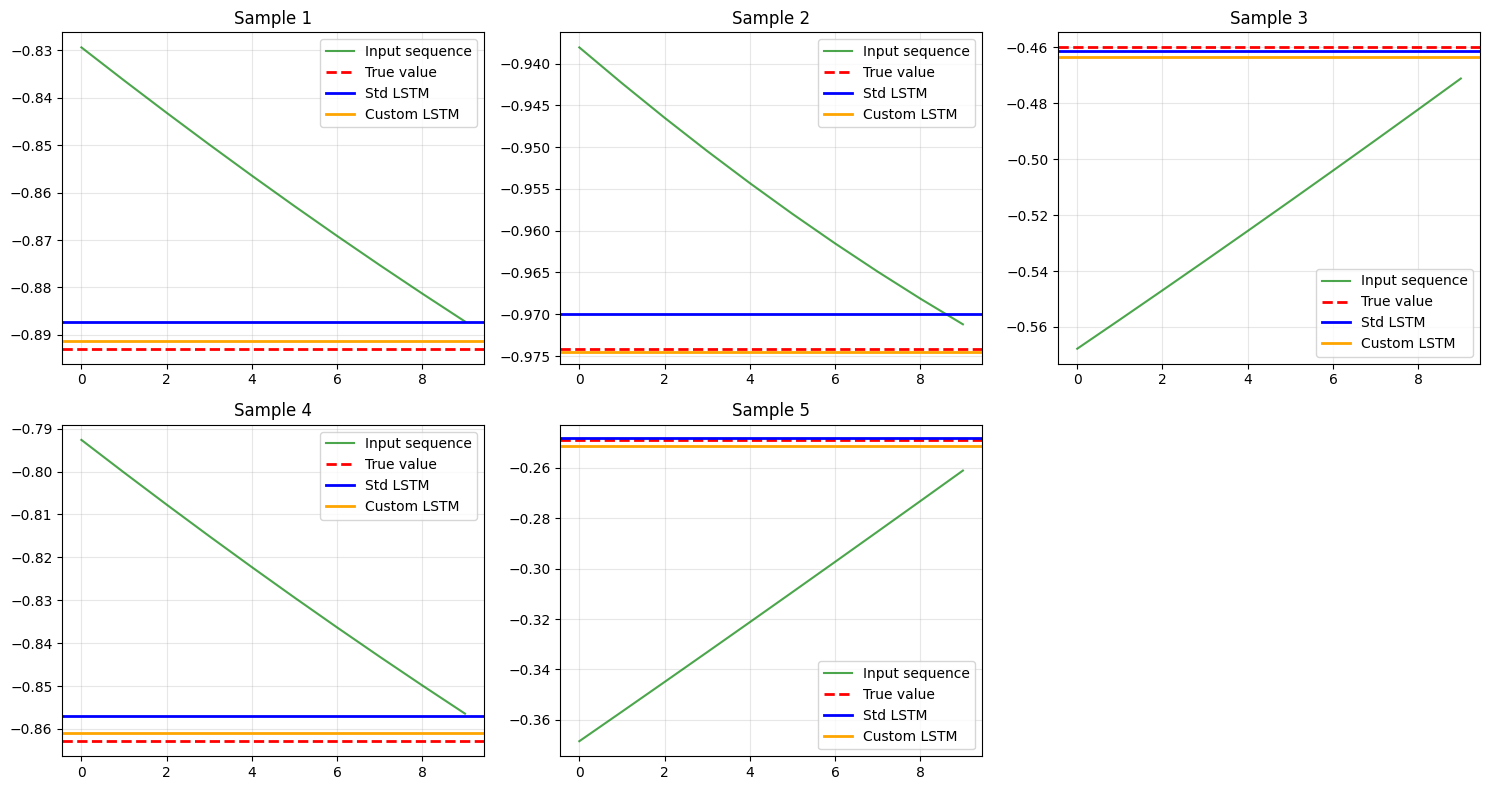

In [23]:
plot_predictions_comparison(model_std, model_cust, X_val, y_val)

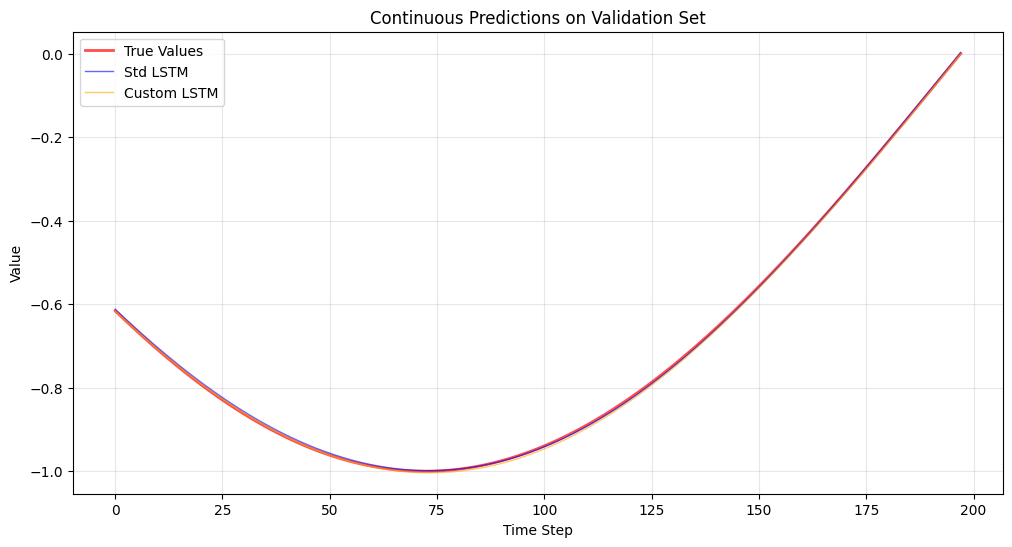

In [24]:
def plot_continuous_predictions(model_std, model_cust, X_val, y_val):
    """Непрерывные предсказания на всей validation выборке"""
    device = next(model_std.parameters()).device

    model_std.eval()
    model_cust.eval()

    with torch.no_grad():
        pred_std = model_std(X_val.to(device)).cpu().numpy()
        pred_cust = model_cust(X_val.to(device)).cpu().numpy()

    y_true = y_val.numpy()

    plt.figure(figsize=(12, 6))

    # True values
    plt.plot(y_true, 'r-', alpha=0.7, linewidth=2, label='True Values')

    # Predictions
    plt.plot(pred_std, 'b-', alpha=0.6, linewidth=1, label='Std LSTM')
    plt.plot(pred_cust, 'orange', alpha=0.6, linewidth=1, label='Custom LSTM')

    plt.title('Continuous Predictions on Validation Set')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_continuous_predictions(model_std, model_cust, X_val, y_val)

## Results and Conclusion

### 1. Numerical Equivalence
- **Forward Pass**: Outputs identical to PyTorch LSTM (difference < 1e-7)
- **Backward Pass**: Gradients match exactly (difference < 1e-7)
- **Training Dynamics**: Nearly identical loss curves

### 2. Performance on Real Task
**Sine Wave Prediction Task:**
- Standard LSTM Final Loss: 0.000023
- Custom LSTM Final Loss: 0.000020  
- **Difference: 0.000003** (negligible!)

### 3. Prediction Quality
**Error Distribution Analysis:**
- Both models achieve high precision
- Error distributions are virtually identical
- Custom LSTM performs comparable on validation set

## Technical Implementation

### Core Components Implemented:
- **LSTM Cell** with all 4 gates (input, forget, candidate, output)
- **Proper weight initialization** (PyTorch-compatible)
- **Vectorized operations** using tensor chunking
- **Gradient computation** via autograd
- **Batch processing** support

## Interesting Publications

- The task, without a solution, was taken from [here](https://github.com/Exorust/TorchLeet/tree/main/torch/medium)
- [Long Short-Term Memory Based Recurrent Neural Network Architectures for Large Vocabulary Speech Recognition. Haşim Sak, Andrew Senior, Françoise Beaufays. 2014](https://arxiv.org/abs/1402.1128)
- [doc.pytorch: LSTM](https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html)